# Построение модели прогнозирования обращений в лечебные учреждения.

## Формулировка задачи:
Требуется обучить модель предсказания факта обращения застрахованного в январе 2022. Т.е., требуется классифицировать застрахованных на 2 класса: 1 - застрахованный обратился в январе 2022 года, 0 - застрахованный не обратился в январе 22 года.

Представленны данные об обращении застрахованных по ДМС в лечебные учреждения за 2021 год с указанием даты обращения, количества полученных медицинских услуг и их суммарной стоимости. Кроме того, доступна информация о поле и возрасте пациентов.

Последовательность решения задачи:
1. Загрузка и анализ данных.
2. Подготовка данных.
3. Обучение и выбор моделей.
4. Тестирование модели.
5. Вывод.

In [2]:
# Импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tsfresh import extract_features, select_features
from tsfresh.feature_extraction import MinimalFCParameters, EfficientFCParameters
from tsfresh import extract_relevant_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction.settings import EfficientFCParameters
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier

from catboost import CatBoostClassifier

import shap
from lightgbm import LGBMClassifier
pd.set_option('display.max_columns', None)
%matplotlib inline

In [3]:
# Константы
SEED = 5555

## 1. Загрузка и анализ данных

### 1.1 Загрузка данных и первый взгляд

In [5]:
# Загрузим набор данных и преобразуем колонку с датами в формат datetime
df = pd.read_csv('MainsLab_data_DS_22.csv', parse_dates=['service_date'])

In [6]:
df.head(10)

,insured,service_date,sex_id,age_for_service_date,serv_count,serv_amount
0,125045,2021-03-03,1.0,6,2.0,2260.0
1,125045,2021-04-11,1.0,6,1.0,1600.0
2,125045,2021-04-18,1.0,6,5.0,4510.0
3,125045,2021-04-23,1.0,6,1.0,380.0
4,125045,2021-06-09,1.0,6,1.0,2500.0
5,125045,2021-11-24,1.0,7,2.0,4100.0
6,125045,2022-01-17,1.0,7,6.0,6540.0
7,125046,2021-06-15,2.0,28,2.0,2610.0
8,125046,2021-06-17,2.0,28,5.0,2410.0
9,125046,2021-06-18,2.0,28,1.0,1300.0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 764333 entries, 0 to 764332
Data columns (total 6 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   insured               764333 non-null  int64         
 1   service_date          764333 non-null  datetime64[ns]
 2   sex_id                764129 non-null  float64       
 3   age_for_service_date  764333 non-null  int64         
 4   serv_count            764333 non-null  float64       
 5   serv_amount           764333 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(2)
memory usage: 35.0 MB


In [9]:
df.describe()

,insured,sex_id,age_for_service_date,serv_count,serv_amount
count,7.643330e+05,764129.000000,764333.000000,764333.000000,764333.000000
mean,4.730479e+05,1.653746,34.925981,2.360192,2242.992679
std,1.959460e+05,0.475776,16.035400,4.479210,2877.117835
min,1.250450e+05,1.000000,0.000000,0.000000,0.000000
25%,2.658610e+05,1.000000,28.000000,1.000000,921.000000
50%,5.167940e+05,2.000000,36.000000,1.000000,1450.000000
75%,6.284420e+05,2.000000,45.000000,3.000000,2610.000000
max,1.226151e+06,2.000000,120.000000,2103.000000,386800.000000


In [7]:
print('количество дубликатов =', df.duplicated().sum())

количество дубликатов = 52


In [8]:
# Рассмотрим дубликаты ближе
df[df.duplicated()].head()

,insured,service_date,sex_id,age_for_service_date,serv_count,serv_amount
13059,146008,2021-03-25,2.0,44,1.0,1500.0
32378,159039,2021-02-18,2.0,44,2.0,2160.0
63032,178089,2021-01-22,2.0,31,1.0,1600.0
64365,178732,2021-08-14,2.0,31,2.0,1080.0
71397,185867,2021-03-27,2.0,39,1.0,2800.0


In [9]:
# Возьмём один дубликат и посмотрим на него в контексте остальных строк по данному клиенту
df[df['insured'] == 146008]

,insured,service_date,sex_id,age_for_service_date,serv_count,serv_amount
13054,146008,2021-01-14,2.0,44,5.0,3610.0
13055,146008,2021-01-20,2.0,44,2.0,2600.0
13056,146008,2021-01-28,2.0,44,1.0,1100.0
13057,146008,2021-03-22,2.0,44,1.0,1500.0
13058,146008,2021-03-25,2.0,44,1.0,1500.0
13059,146008,2021-03-25,2.0,44,1.0,1500.0
13060,146008,2021-03-26,2.0,44,2.0,2200.0
13061,146008,2021-03-29,2.0,44,1.0,1100.0
13062,146008,2021-04-06,2.0,44,1.0,1100.0


**Вывод:** 
1. Данные загружены.
2. Пропуски присутствуют в колонке `sex_id`.
3. Присутствуют полные дубликаты строк. Это два обращения одного и того-же клиента в один день или ошибка?

### 1.2 Рассмотрим датасет ближе

Каждая стока набора данных характеризует обращение за медицинской помощью одного клиента в определённую дату(количество и стоимость обращений).

#### 1.2.1 Уникальный ид застрахованного лица

In [10]:
df['insured'].value_counts().describe()

count    137645.000000
mean          5.552930
std           6.438355
min           1.000000
25%           1.000000
50%           3.000000
75%           7.000000
max         113.000000
Name: insured, dtype: float64

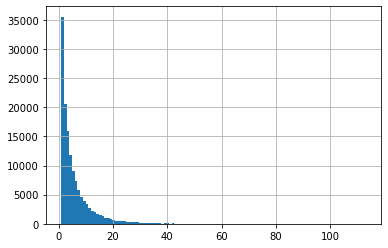

In [11]:
df['insured'].value_counts().hist(bins=113);

**Вывод:** В наборе данных содержаться сведенья о 137645 клиентах. Большинство из них обращались за медицинской помощью 1-3 раза. Но есть и некоторые клиенты, которые обращались более 100 раз.

#### 1.2.2 Пол застрахованного

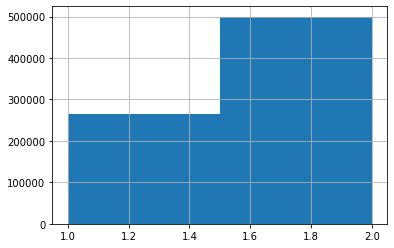

In [12]:
df['sex_id'].hist(bins=2);

**Вывод:** Данные о поле клиентов распределены в отношении 1 к 2.

#### 1.2.3 Дата оказания услуги

In [13]:
df['service_date'].min()

Timestamp('2021-01-01 00:00:00')

In [14]:
df['service_date'].max()

Timestamp('2022-01-31 00:00:00')

Даты обращений лежат в диапозоне 1 января 2021 года - 31 января 2022 года.

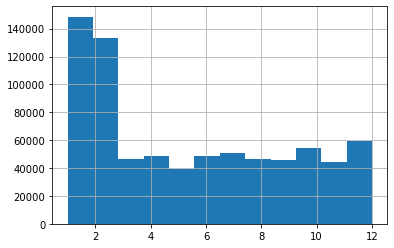

In [15]:
df['service_date'].dt.month.hist(bins=12);

In [16]:
df[df['service_date'].dt.month == 2]['service_date'].count()

133304

In [17]:
df[df['service_date'].dt.month == 1]['service_date'].dt.year.value_counts()

2021    101596
2022     46943
Name: service_date, dtype: int64

По месяцам обращения за медицинской помощью для периода с марта 2021г. по январь 2022г. лежат в диапозоне от 40000 до 60000
Январь и февраль 2021 года выбиваются из этого распределения со 101596 и 133304 соответственно. Возможно в эти месяцы ещё не пропало влияние пандемии коронавируса.

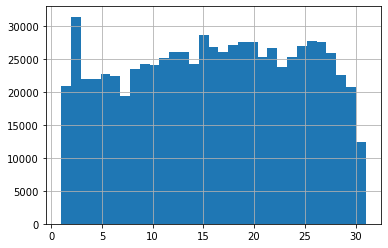

In [18]:
df['service_date'].dt.day.hist(bins=31);

По дням внутри месяца количество обращений распределено прауктически равномерно. Разве что выбивается число 2, но не значительно.

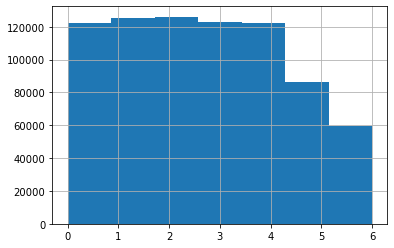

In [19]:
df['service_date'].dt.dayofweek.hist(bins=7);

По дням недели распределение обращений вполне закономерно. В буднии дни обращений поровну, в субботу меньше в воскресенье ещё меньше. Это обьясняется тем, что в будни осуществляется как плановый приём так и приём по для оказания неотложной медицинской помощи. Выходные обращаются, как правило, только за экстренной помощью.

#### 1.2.4 Возраст застрахованного на дату оказания услуги

<AxesSubplot:>

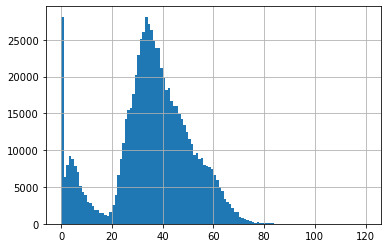

In [20]:
df['age_for_service_date'].hist(bins=120)

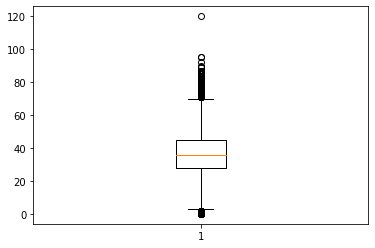

In [21]:
plt.boxplot(df['age_for_service_date']);

In [22]:
df['age_for_service_date']

0          6
1          6
2          6
3          6
4          6
          ..
764328    29
764329    29
764330    29
764331    58
764332    58
Name: age_for_service_date, Length: 764333, dtype: int64

**Вывод:** 
1. Возраст клиентов лежит в диапозоне от 0 до 120 лет.
2. 120 - это скорее всего ошибка в данных. Возможно это 12 лет.
3. Слишком много нулевых значений. Возможно большая часть нулевых значений - это пропуски возраста.
4. Распределение клиентов по возрасту довольно интересное. Больнинство клиентов имеют возраст от 28 до 45 лет. Средний возраст клиентов = 35 лет. Также, много клиентов с нулевым возрастом. Это говорит но том, что очень часто обращаются за мед помощью родители новорожденных. Далее, имеется локальный максимум обращений в возрасте около пяти лет, со спадом активности до совершеннолетия. Далее идёт возрастание обращений.

#### 1.2.5 Количество оказанных услуг

<AxesSubplot:>

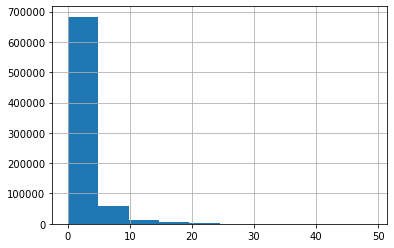

In [23]:
# df['serv_count'].hist()
df[df['serv_count'] < 50]['serv_count'].hist()

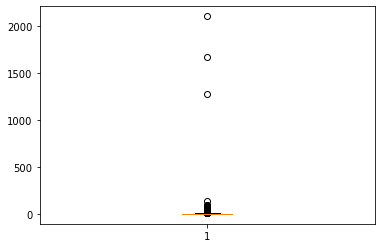

In [24]:
plt.boxplot(df['serv_count']);

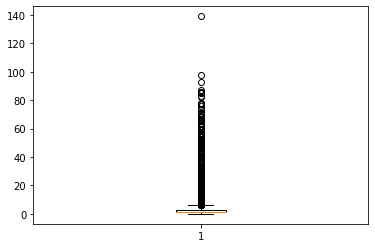

In [25]:
plt.boxplot(df[df['serv_count'] < 500]['serv_count']);

In [26]:
# Посмотрим на записи где количество услуг = 0
df[df['serv_count'] == 0]

,insured,service_date,sex_id,age_for_service_date,serv_count,serv_amount
153771,235243,2021-04-10,2.0,37,0.0,855.0
167522,244392,2021-04-30,2.0,29,0.0,855.0


**Вывод:** Большинство клиентов обращались за помощью в один день от 1 до 3 раз. Однако в наборе данных присутствуют записи об обращениях в одну дату до 2610 раз. Это, мягко говоря, сомнительно. Возможно, в данном наборе данных эта колонка содержит не только количество обращений в день, но и какие-либо другие значения? Например количество медицинских препаратов, израсходованных для лечения клиента? Или их объём? Также, вызывают вопросы нулевые значения в данной колонке. Это обращение застрахованног, но услуга не была оказана? Но стоимость услуг не нулевая - скорее всего это ошибка. 

#### 1.2.6 Суммарная цена оказанных услуг

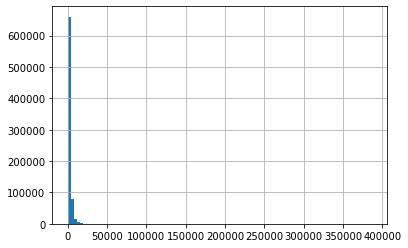

In [27]:
df[df['serv_amount'] < 500000]['serv_amount'].hist(bins=100);

In [28]:
df[df['serv_amount'] > 200000]

,insured,service_date,sex_id,age_for_service_date,serv_count,serv_amount
60170,176296,2021-01-08,1.0,62,2.0,276962.73
60195,176296,2021-02-12,1.0,62,3.0,274593.26
351879,501588,2021-01-22,2.0,24,20.0,386800.00


In [29]:
df[df['insured'] == 501588]

,insured,service_date,sex_id,age_for_service_date,serv_count,serv_amount
351878,501588,2021-01-12,2.0,24,2.0,2100.0
351879,501588,2021-01-22,2.0,24,20.0,386800.0
351880,501588,2021-02-17,2.0,24,10.0,5200.0
351881,501588,2021-04-23,2.0,25,1.0,1500.0
351882,501588,2021-05-24,2.0,25,1.0,1500.0
351883,501588,2021-05-25,2.0,25,1.0,1400.0
351884,501588,2021-05-31,2.0,25,1.0,1500.0
351885,501588,2021-06-04,2.0,25,2.0,2490.0
351886,501588,2021-06-07,2.0,25,1.0,990.0
351887,501588,2021-10-20,2.0,25,1.0,1500.0


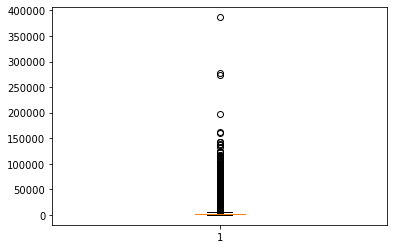

In [30]:
plt.boxplot(df['serv_amount']);

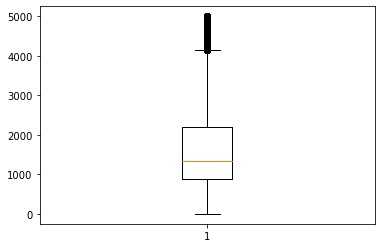

In [31]:
plt.boxplot(df[df['serv_amount'] < 5000]['serv_amount']);

**Вывод:** Для большинства обращений, стоимость медицинских услуг лежит в диапозоне 900-2600. В некоторых случаях стоимость достигает очень больших значений- до 400000. Это ошибки или дорогостиящие операции?

#### 1.2.7 Построим матрицу корреляций

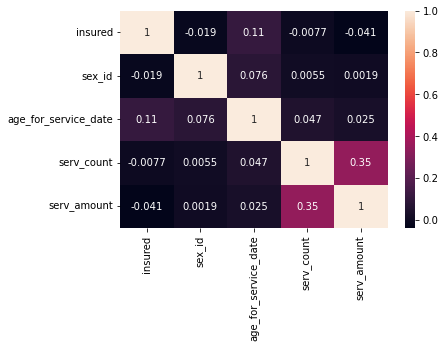

In [32]:
sns.heatmap(df.corr(), annot=True);

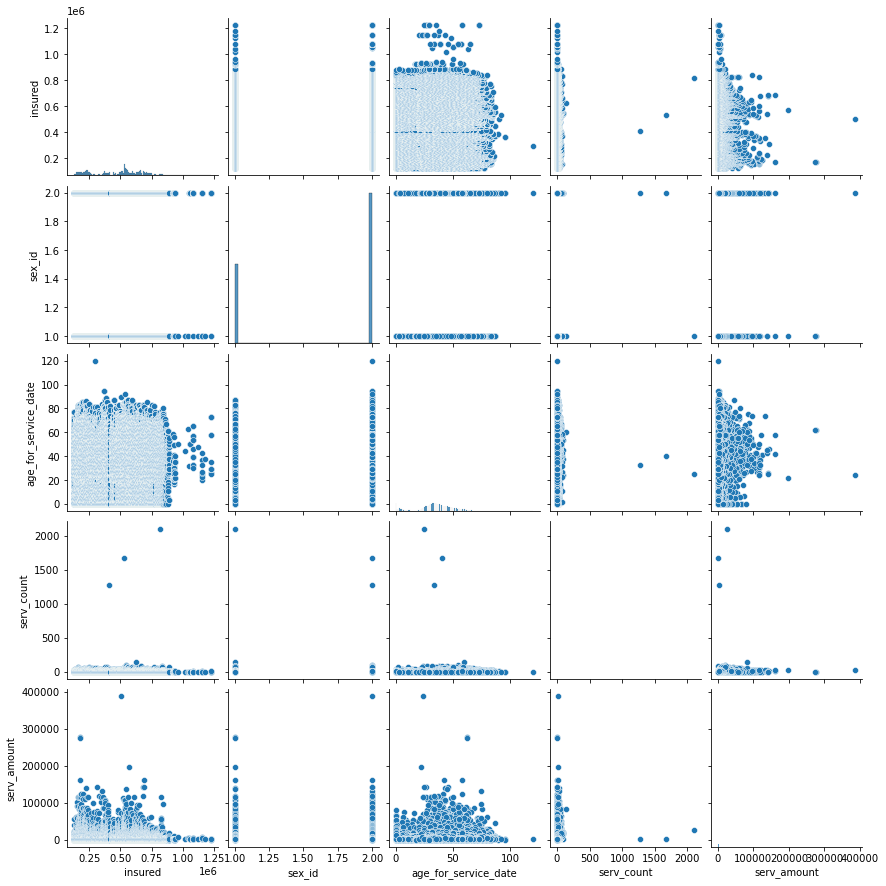

In [33]:
sns.pairplot(df);

**Вывод:** Сильных корреляционных зависимостей между значениями в разных колонках датасета не обнаружено.

**Вывод по разделу**
1. Набор данных содержит сведенья об обращении застрахованных по ДМС в лечебные учреждения в период с 01 января 2021 года по 31 января 2022 года.
2. В наборе данных содержаться сведенья о 137645 клиентах. Большинство из них обращались за медицинской помощью 1-3 раза за вышеуказанный период. Но есть и некоторые клиенты, которые обращались более 100 раз.
3. Большинство клиентов в один день получили от 1 до 3 услуг. Однако в наборе данных присутствуют записи о получении в одну дату до 2610 услуг. Также присутствуют нулевые значения. Не понятно что считается услугой? Это количество обращений к врачу или количество потраченных ресурсов на пациента?
4. Для большинства клиентов, стоимость медицинских услуг за один день лежит в диапозоне 900-2600. В некоторых случаях стоимость достигает очень больших значений- до 400000. Это ошибки или дорогостиящие операции?
5. Данные о поле клиентов распределены в отношении 1 к 2.
6. Распределение клиентов по возрасту довольно интересное. Больнинство клиентов имеют возраст от 28 до 45 лет. Средний возраст клиентов = 35 лет. Также, много клиентов с нулевым возрастом. Это говорит но том, что очень часто обращаются за мед помощью родители новорожденных. Далее, имеется локальный максимум обращений в возрасте около пяти лет, со спадом активности до совершеннолетия. Далее идёт возрастание обращений до 35 лет с последующим спадом. Присутствуют клиенты с возрастом 120 лет - возможно это ошибка.
7. Пропуски присутствуют в колонке `sex_id`.
8. Присутствует 52 полных дубликата строк. Скорее всего - это ошибка ввода данных, которую следует удалить. Однако, возможно, это два обращения за один день.
9. Сильные корреляционные зависимостей между значениями в разных колонках датасета отсутствуют.

По результатам анализа данных, для лучшего понимания данных и более качественной обработки и будущей модели, необходимо задать следующие вопросы тому, кто составлял датасет:
1. Как формировалась колонка с количеством услуг? Являются-ли нормальными данные с очень большим количеством услуг?
2. До каких пределов может доходить стоимость услуг?
3. Правда-ли существует клиент с возрастом 120 лет или это ошибка. Большое количество клиентов с нулевым возрастом - это достоверные сведенья, или это пропуски истинных значений?
4. Дубликаты строк - это ошибки или два обращения в один день?

## 2. Подготовка данных

1. Предобработка.
    - Дубликаты - удалить
    - Обработка пропусков.
    - Выбросы - обработать
2. Генерация доп признаков:
    - Признаки на основе даты обращения
    - Целевой признак
3. Группировка по ID клиента и извлечение признаков
4. Формирование выборок.

### 2.1 Предобработка
    - Удалим дубликаты
    - Обработаем пропуски. Так как восстановить значения неоткуда, заполним наиболее частым значением.
    - Обработаем выбросы. Удалим только самые большие выбросы в колонках `serv_amount` и `serv_count`.
    - Обработаем недостоверные данные

In [10]:
# Удалим дубликаты
df = df.drop_duplicates()

In [11]:
# Заполним пропуски наиболее частым значением
df['sex_id'] = df['sex_id'].fillna(2)

In [12]:
# Обработка выбросов
df = df[df['serv_amount'] < 200000]
df = df[df['serv_count'] < 500]

In [13]:
# Заменим на 1 количество услуг равное нулю
df.loc[df['serv_count'] == 0, 'serv_count'] = 1

**Вывод:** Дубликаты удалены, пропуски заполнены, выбросы обработаны.

### 2.2 Генерация признаков

1. Выделим дополнительные признаки.
2. Выделим целевой признак.

#### 2.2.1 Формирование признаков

На данном этапе сложно сказать какой признак будет положительно влиять на работу модели, поэтому выделим из даты несколько признаков, а в последующей работе оставим наиболее эффективные:
1. Признаки выделенные из даты оказания услуг:
    - день месяца
    - день недели
    - день года
    - месяц
2. Другие признаки:
    - средняя цена одной услуги за одно обращение

In [14]:
# День
df['day'] = df['service_date'].dt.day
# День недели
df['day_of_week'] = df['service_date'].dt.dayofweek
# День в году
df['day_of_year'] = df['service_date'].dt.dayofyear
# Месяц
df['month'] = df['service_date'].dt.month

In [15]:
# Признак цена единицы мед услуг
df['serv_amuont_perone'] = df['serv_amount'] / df['serv_count']

#### 2.2.2 Выделение целевого признака

Целевым признаком является факт обращения застрахованного в январе 2022 года. `1`-обращался, `0`- не обращался.

Для выделения целевого признака:
1. Сформируем колонку `label` в которую запишем `1` - если в строка относится к обращению в январе 2022г и `0` - если нет.
2. Заполним единицами все строки, в которых присутствуют пользователи обратившиеся в январе 2022г. 
3. Теперь строки с обращениями в январе 2022 г. нам больше не нужны, так как они не будут участвовать в работе модели(иначе это будет утечкой данных). Удалим их.

In [16]:
# Целевой признак
df['label'] = (df['service_date'].dt.year == 2022)*1
# Пока у нас единицы только в строках с обращением в январе 2022, 
# а нам надо чтобы 1 были во всех строках с индексом у которых есть хотя-бы одна единица в целевой переменной
df = df.merge(df.groupby('insured')['label'].max(), on='insured')
# Удалим лишнюю колонку
df = df.drop(columns=['label_x'])
# Переименуем колонку с итоговым целевым признаком
df = df.rename({'label_y': 'label'}, axis=1)

In [19]:
df.head(50)

,insured,service_date,sex_id,age_for_service_date,serv_count,serv_amount,day,day_of_week,day_of_year,month,serv_amuont_perone,label
0,125045,2021-03-03,1.0,6,2.0,2260.0,3,2,62,3,1130.000000,1
1,125045,2021-04-11,1.0,6,1.0,1600.0,11,6,101,4,1600.000000,1
2,125045,2021-04-18,1.0,6,5.0,4510.0,18,6,108,4,902.000000,1
3,125045,2021-04-23,1.0,6,1.0,380.0,23,4,113,4,380.000000,1
4,125045,2021-06-09,1.0,6,1.0,2500.0,9,2,160,6,2500.000000,1
5,125045,2021-11-24,1.0,7,2.0,4100.0,24,2,328,11,2050.000000,1
6,125045,2022-01-17,1.0,7,6.0,6540.0,17,0,17,1,1090.000000,1
7,125046,2021-06-15,2.0,28,2.0,2610.0,15,1,166,6,1305.000000,0
8,125046,2021-06-17,2.0,28,5.0,2410.0,17,3,168,6,482.000000,0
9,125046,2021-06-18,2.0,28,1.0,1300.0,18,4,169,6,1300.000000,0


<AxesSubplot:>

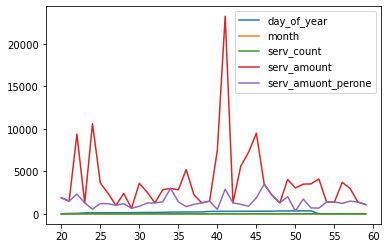

In [27]:
df[df['insured'] == 125048][['day_of_year',
                             'month',
                             'serv_count',
                             'serv_amount',
                             'serv_amuont_perone'
                            ]].plot()

<AxesSubplot:>

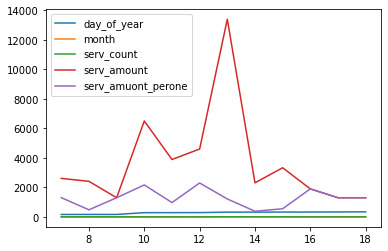

In [26]:
df[df['insured'] == 125046][['day_of_year',
                             'month',
                             'serv_count',
                             'serv_amount',
                             'serv_amuont_perone'
                            ]].plot()

In [42]:
# после выделения целевого признака, удалим записи с обращениями в январе 2022г.
df = df[df['service_date'].dt.year == 2021]

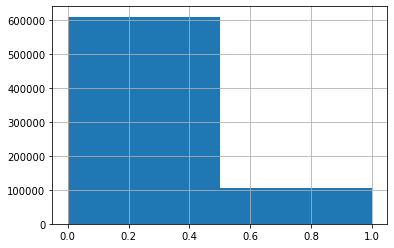

In [43]:
df['label'].hist(bins=2);

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 717338 entries, 0 to 764220
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   insured               717338 non-null  int64         
 1   service_date          717338 non-null  datetime64[ns]
 2   sex_id                717338 non-null  float64       
 3   age_for_service_date  717338 non-null  int64         
 4   serv_count            717338 non-null  float64       
 5   serv_amount           717338 non-null  float64       
 6   day                   717338 non-null  int64         
 7   day_of_week           717338 non-null  int64         
 8   day_of_year           717338 non-null  int64         
 9   month                 717338 non-null  int64         
 10  serv_amuont_perone    717338 non-null  float64       
 11  label                 717338 non-null  int32         
dtypes: datetime64[ns](1), float64(4), int32(1), int64(6)
memor

**Вывод** 
1. Сформировали признаки на основе даты обращения.
2. Сформировали колонку целевого признака.
3. Удалили строки с обращениями в январе 2022 года.

### 2.3 Извлечение признаков

На данном этапе имеем набор данных с обработанными пропусками и дубликатами, а также со сформрованными дополнительными признаками и целевым признаком. Однако, такой датасет ещё не готов для построения модели машинного обучения. Для каждого пользователя мы имеем по несколько обращений, которые складываються во временной ряд. Для формирования окончательного набора данных, который можно будет подать в модель, необходимо сгруппировать данные по ИД застрахованного и извлечь характеристики временного ряда. Для этого воспользуемся методами библиотеки `tsfresh`. Извлекать признаки временных рядов будем из всех колонок кроме `sex_id` и `age_for_service_date` так как они практически не меняются(только возраст может изменться на +1 год), и по сути являются категориальными признаками.

In [45]:
%%time
# Извлечение признаков
df_extracted_features = extract_features(df.drop(['sex_id', 'age_for_service_date', 'label'], axis=1),
                                         default_fc_parameters=MinimalFCParameters(),#EfficientFCParameters(),
                                         column_id='insured',
                                         column_sort='service_date',
                                         # disable_progressbar=False,
                                         # n_jobs=0,
                                        )

Feature Extraction: 100%|██████████| 20/20 [02:08<00:00,  6.44s/it]


CPU times: total: 2min 10s
Wall time: 2min 18s


In [46]:
df_extracted_features.head()

,serv_count__sum_values,serv_count__median,serv_count__mean,serv_count__length,serv_count__standard_deviation,serv_count__variance,serv_count__root_mean_square,serv_count__maximum,serv_count__minimum,serv_amount__sum_values,serv_amount__median,serv_amount__mean,serv_amount__length,serv_amount__standard_deviation,serv_amount__variance,serv_amount__root_mean_square,serv_amount__maximum,serv_amount__minimum,day__sum_values,day__median,day__mean,day__length,day__standard_deviation,day__variance,day__root_mean_square,day__maximum,day__minimum,day_of_week__sum_values,day_of_week__median,day_of_week__mean,day_of_week__length,day_of_week__standard_deviation,day_of_week__variance,day_of_week__root_mean_square,day_of_week__maximum,day_of_week__minimum,day_of_year__sum_values,day_of_year__median,day_of_year__mean,day_of_year__length,day_of_year__standard_deviation,day_of_year__variance,day_of_year__root_mean_square,day_of_year__maximum,day_of_year__minimum,month__sum_values,month__median,month__mean,month__length,month__standard_deviation,month__variance,month__root_mean_square,month__maximum,month__minimum,serv_amuont_perone__sum_values,serv_amuont_perone__median,serv_amuont_perone__mean,serv_amuont_perone__length,serv_amuont_perone__standard_deviation,serv_amuont_perone__variance,serv_amuont_perone__root_mean_square,serv_amuont_perone__maximum,serv_amuont_perone__minimum
125045,12.0,1.5,2.000000,6.0,1.414214,2.000000,2.449490,5.0,1.0,15350.00,2380.0,2558.333333,6.0,1410.773035,1.990281e+06,2921.532132,4510.0,380.00,88.0,14.5,14.666667,6.0,7.630349,58.222222,16.532796,24.0,3.0,22.0,3.0,3.666667,6.0,1.795055,3.222222,4.082483,6.0,2.0,872.0,110.5,145.333333,6.0,86.536441,7488.555556,169.145894,328.0,62.0,32.0,4.0,5.333333,6.0,2.687419,7.222222,5.972158,11.0,3.0,8562.000000,1365.000000,1427.000000,6.0,710.566675,504905.000000,1594.124838,2500.000000,380.000000
125046,43.0,2.5,3.583333,12.0,2.899952,8.409722,4.609772,11.0,1.0,44840.00,2510.0,3736.666667,12.0,3266.079029,1.066727e+07,4962.857040,13390.0,1300.00,215.0,18.0,17.916667,12.0,5.880169,34.576389,18.856917,27.0,4.0,40.0,3.5,3.333333,12.0,2.094968,4.388889,3.937004,6.0,0.0,3371.0,309.0,280.916667,12.0,67.683649,4581.076389,288.955446,345.0,166.0,116.0,10.5,9.666667,12.0,2.211083,4.888889,9.916317,12.0,6.0,15183.439394,1300.000000,1265.286616,12.0,596.667826,356012.494546,1398.914835,2300.000000,385.000000
125047,8.0,8.0,8.000000,1.0,0.000000,0.000000,8.000000,8.0,8.0,7060.00,7060.0,7060.000000,1.0,0.000000,0.000000e+00,7060.000000,7060.0,7060.00,3.0,3.0,3.000000,1.0,0.000000,0.000000,3.000000,3.0,3.0,3.0,3.0,3.000000,1.0,0.000000,0.000000,3.000000,3.0,3.0,154.0,154.0,154.000000,1.0,0.000000,0.000000,154.000000,154.0,154.0,6.0,6.0,6.000000,1.0,0.000000,0.000000,6.000000,6.0,6.0,882.500000,882.500000,882.500000,1.0,0.000000,0.000000,882.500000,882.500000,882.500000
125048,119.0,2.0,3.606061,33.0,4.022206,16.178145,5.402020,19.0,1.0,136710.00,2840.0,4142.727273,33.0,4231.730266,1.790754e+07,5921.970137,23230.0,660.00,570.0,19.0,17.272727,33.0,8.729166,76.198347,19.353177,31.0,1.0,85.0,3.0,2.575758,33.0,2.074817,4.304867,3.307475,6.0,0.0,7476.0,228.0,226.545455,33.0,95.667699,9152.308540,245.916961,362.0,32.0,261.0,8.0,7.909091,33.0,3.088234,9.537190,8.490637,12.0,2.0,47492.128864,1300.000000,1439.155420,33.0,709.372258,503209.000894,1604.486623,3500.000000,338.888889
125049,21.0,2.5,3.500000,6.0,2.217356,4.916667,4.143268,7.0,1.0,20301.92,1581.7,3383.653333,6.0,3903.064475,1.523391e+07,5165.561168,12073.0,1259.16,136.0,22.5,22.666667,6.0,4.027682,16.222222,23.021729,28.0,17.0,21.0,3.0,3.500000,6.0,1.892969,3.583333,3.979112,6.0,1.0,136.0,22.5,22.666667,6.0,4.027682,16.222222,23.021729,28.0,17.0,6.0,1.0,1.000000,6.0,0.000000,0.000000,1.000000,1.0,1.0,5518.494286,778.843333,919.749048,6.0,459.536477,211173.773776,1028.159562,1724.714286,274.933333


In [47]:
df_extracted_features.shape

(131270, 63)

In [48]:
# К полученному набору данных добавим целевой признак , пол и возраст
df_extracted_features = df_extracted_features.merge(df.groupby('insured')['label', 'sex_id', 'age_for_service_date'].first(), right_index=True, left_index=True)

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


In [49]:
df_extracted_features.head()

,serv_count__sum_values,serv_count__median,serv_count__mean,serv_count__length,serv_count__standard_deviation,serv_count__variance,serv_count__root_mean_square,serv_count__maximum,serv_count__minimum,serv_amount__sum_values,serv_amount__median,serv_amount__mean,serv_amount__length,serv_amount__standard_deviation,serv_amount__variance,serv_amount__root_mean_square,serv_amount__maximum,serv_amount__minimum,day__sum_values,day__median,day__mean,day__length,day__standard_deviation,day__variance,day__root_mean_square,day__maximum,day__minimum,day_of_week__sum_values,day_of_week__median,day_of_week__mean,day_of_week__length,day_of_week__standard_deviation,day_of_week__variance,day_of_week__root_mean_square,day_of_week__maximum,day_of_week__minimum,day_of_year__sum_values,day_of_year__median,day_of_year__mean,day_of_year__length,day_of_year__standard_deviation,day_of_year__variance,day_of_year__root_mean_square,day_of_year__maximum,day_of_year__minimum,month__sum_values,month__median,month__mean,month__length,month__standard_deviation,month__variance,month__root_mean_square,month__maximum,month__minimum,serv_amuont_perone__sum_values,serv_amuont_perone__median,serv_amuont_perone__mean,serv_amuont_perone__length,serv_amuont_perone__standard_deviation,serv_amuont_perone__variance,serv_amuont_perone__root_mean_square,serv_amuont_perone__maximum,serv_amuont_perone__minimum,label,sex_id,age_for_service_date
125045,12.0,1.5,2.000000,6.0,1.414214,2.000000,2.449490,5.0,1.0,15350.00,2380.0,2558.333333,6.0,1410.773035,1.990281e+06,2921.532132,4510.0,380.00,88.0,14.5,14.666667,6.0,7.630349,58.222222,16.532796,24.0,3.0,22.0,3.0,3.666667,6.0,1.795055,3.222222,4.082483,6.0,2.0,872.0,110.5,145.333333,6.0,86.536441,7488.555556,169.145894,328.0,62.0,32.0,4.0,5.333333,6.0,2.687419,7.222222,5.972158,11.0,3.0,8562.000000,1365.000000,1427.000000,6.0,710.566675,504905.000000,1594.124838,2500.000000,380.000000,1,1.0,6
125046,43.0,2.5,3.583333,12.0,2.899952,8.409722,4.609772,11.0,1.0,44840.00,2510.0,3736.666667,12.0,3266.079029,1.066727e+07,4962.857040,13390.0,1300.00,215.0,18.0,17.916667,12.0,5.880169,34.576389,18.856917,27.0,4.0,40.0,3.5,3.333333,12.0,2.094968,4.388889,3.937004,6.0,0.0,3371.0,309.0,280.916667,12.0,67.683649,4581.076389,288.955446,345.0,166.0,116.0,10.5,9.666667,12.0,2.211083,4.888889,9.916317,12.0,6.0,15183.439394,1300.000000,1265.286616,12.0,596.667826,356012.494546,1398.914835,2300.000000,385.000000,0,2.0,28
125047,8.0,8.0,8.000000,1.0,0.000000,0.000000,8.000000,8.0,8.0,7060.00,7060.0,7060.000000,1.0,0.000000,0.000000e+00,7060.000000,7060.0,7060.00,3.0,3.0,3.000000,1.0,0.000000,0.000000,3.000000,3.0,3.0,3.0,3.0,3.000000,1.0,0.000000,0.000000,3.000000,3.0,3.0,154.0,154.0,154.000000,1.0,0.000000,0.000000,154.000000,154.0,154.0,6.0,6.0,6.000000,1.0,0.000000,0.000000,6.000000,6.0,6.0,882.500000,882.500000,882.500000,1.0,0.000000,0.000000,882.500000,882.500000,882.500000,0,2.0,53
125048,119.0,2.0,3.606061,33.0,4.022206,16.178145,5.402020,19.0,1.0,136710.00,2840.0,4142.727273,33.0,4231.730266,1.790754e+07,5921.970137,23230.0,660.00,570.0,19.0,17.272727,33.0,8.729166,76.198347,19.353177,31.0,1.0,85.0,3.0,2.575758,33.0,2.074817,4.304867,3.307475,6.0,0.0,7476.0,228.0,226.545455,33.0,95.667699,9152.308540,245.916961,362.0,32.0,261.0,8.0,7.909091,33.0,3.088234,9.537190,8.490637,12.0,2.0,47492.128864,1300.000000,1439.155420,33.0,709.372258,503209.000894,1604.486623,3500.000000,338.888889,1,1.0,17
125049,21.0,2.5,3.500000,6.0,2.217356,4.916667,4.143268,7.0,1.0,20301.92,1581.7,3383.653333,6.0,3903.064475,1.523391e+07,5165.561168,12073.0,1259.16,136.0,22.5,22.666667,6.0,4.027682,16.222222,23.021729,28.0,17.0,21.0,3.0,3.500000,6.0,1.892969,3.583333,3.979112,6.0,1.0,136.0,22.5,22.666667,6.0,4.027682,16.222222,23.021729,28.0,17.0,6.0,1.0,1.000000,6.0,0.000000,0.000000,1.000000,1.0,1.0,5518.494286,778.843333,919.749048,6.0,459.536477,211173.773776,1028.159562,1724.714286,274.933333,0,1.0,1


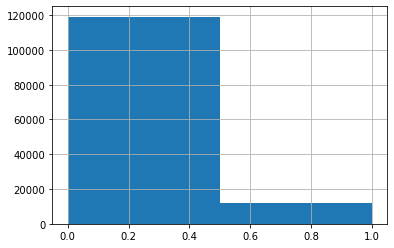

In [50]:
df_extracted_features['label'].hist(bins=2);

In [51]:
df_extracted_features.shape

(131270, 66)

#### 2.3.1 Формирование признаков 

1. Сформируем признак со случайными значениями для последующей оценки важности признаков.
2. Сформируем признак с прогнозируемым днём следующего обращения(Последний день + средний период обращений).

In [52]:
# Добавим случайный признак для последующего анализа важности признаков
df_extracted_features['random'] = np.random.rand(df_extracted_features.shape[0])

In [53]:
# 
df_extracted_features['prognoz_day'] = ((df_extracted_features['day_of_year__maximum'] - df_extracted_features['day_of_year__minimum'])
                                        /(df_extracted_features['day_of_year__length'] - 1) + df_extracted_features['day_of_year__maximum'])


**Вывод**

Набор данных для обучения модели сформирован.

### 2.4 Подготовка выборок для обучения модели

Разделим датасет на три выборки:
- Обучающую - 60%
- Валидационную - 20%
- Тестовую -20%

In [54]:
# Выделим признаки и целевой признак
X = df_extracted_features.drop(['label'], axis=1)
y = df_extracted_features['label']

In [55]:
# Разделим данные на выборки
X_train, X_vt, y_train, y_vt = train_test_split(X, y, test_size=0.4, random_state=SEED)
X_valid, X_test, y_valid, y_test = train_test_split(X_vt, y_vt, test_size=0.5, random_state=SEED)


In [56]:
# Проверим размеры выборок
pd.DataFrame({'X_train':X_train.shape[0],
              'y_train':y_train.shape,
              'X_test':X_test.shape[0],
              'y_test':y_test.shape
})

,X_train,y_train,X_test,y_test
0,78762,78762,26254,26254


**Вывод:** Выборки сформированы.

**Вывод по разделу**

Произведена предобработка данных, выделены дополнительные признаки и целевой признак. Сформирован набор данных для обучения модели и подготовлены выборки



## 3. Обучение моделей

1. Обучим модель CatBoostClassifier и LGBMClassifier, определим важность признаков для каждой из них и определимся с их набором для дальнейшей работы.
2. Обучим несколько моделей с подбором гиперпараметров
3. Выберем лучшую модель и протестируем её на отложенной тестовой выборке, а также проверим её работу на адекватность.

Так как присутствует сильный дисбалланс классов в целевой переменной? в дальнейшей работе в качестве метрики качества модели будем использовать ROC-AUC. Данная метрика отражает как точность, так и полноту классификации.

### 3.1 Обучение моделей и оценка важности признаков

#### 3.1.1 CatBoostClassifier

In [57]:
cat_clf = CatBoostClassifier(verbose=100,
                             auto_class_weights='Balanced',
                             random_state=5555
                            )

cat_clf.fit(X_train, y_train)#, cat_features=['sex_id__minimum', 'age_for_service_date__maximum'])

Learning rate set to 0.066475
0:	learn: 0.6651353	total: 198ms	remaining: 3m 17s
100:	learn: 0.4689794	total: 2.23s	remaining: 19.9s
200:	learn: 0.4503235	total: 4.25s	remaining: 16.9s
300:	learn: 0.4300860	total: 6.2s	remaining: 14.4s
400:	learn: 0.4107914	total: 8.07s	remaining: 12.1s
500:	learn: 0.3944399	total: 9.98s	remaining: 9.94s
600:	learn: 0.3794779	total: 11.9s	remaining: 7.88s
700:	learn: 0.3650920	total: 13.7s	remaining: 5.84s
800:	learn: 0.3513701	total: 15.6s	remaining: 3.87s
900:	learn: 0.3387662	total: 17.5s	remaining: 1.92s
999:	learn: 0.3269516	total: 19.6s	remaining: 0us


In [58]:
predict = cat_clf.predict(X_valid)
roc_auc_score(y_valid, predict)

0.7525757438512949

In [59]:
accuracy_score(y_valid, predict)

0.7887559990858536

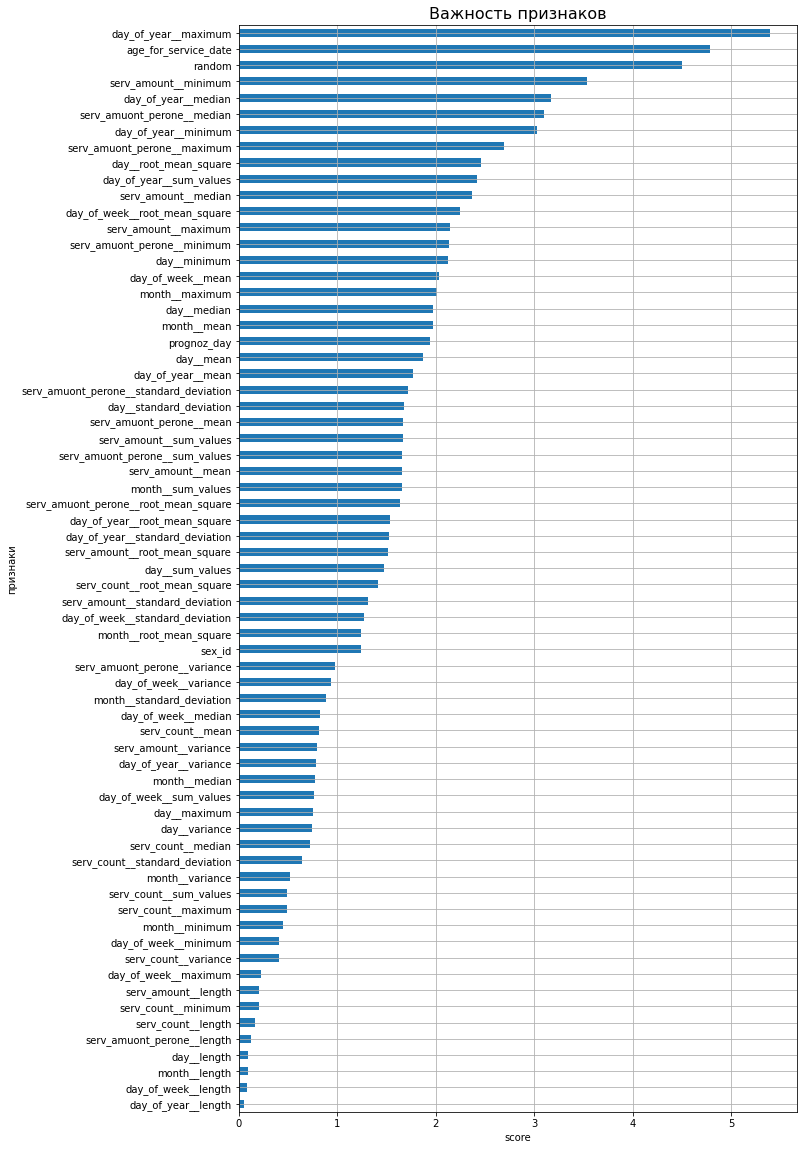

In [60]:
# Выделим признаки
efectiv_score = pd.DataFrame(data={'score': cat_clf.feature_importances_}, 
                            index=X.columns).sort_values(by='score')
# Выведем их на экран
ax = efectiv_score.plot(kind='barh', grid=True, figsize=(10,20), legend=False)
ax.set_title("Важность признаков", fontsize=16)
ax.set_ylabel("признаки")
ax.set_xlabel("score")
plt.show;

**Вывод** 
1. Модель CatBoostClassifier без подбора гиперпараметров показывает качество AUC-ROC=0.74 и accuracy=0.78.
2. Оценка важности признаков говорит нам о том, что, по сути, только два признака эффективны: `day_of_year__maximum`, `age_for_service_date__maximum`. Значимость остальных признаков - ниже уровня случайного признака.

#### 3.1.2 LGBMClassifier

In [61]:
lgbm_clf = LGBMClassifier(class_weight='balanced')
lgbm_clf.fit(X_train, y_train)

LGBMClassifier(class_weight='balanced')

In [62]:
predict = lgbm_clf.predict(X_valid)
roc_auc_score(y_valid, predict)

0.7663202147713892

In [63]:
accuracy_score(y_valid, predict)

0.7497905081130495

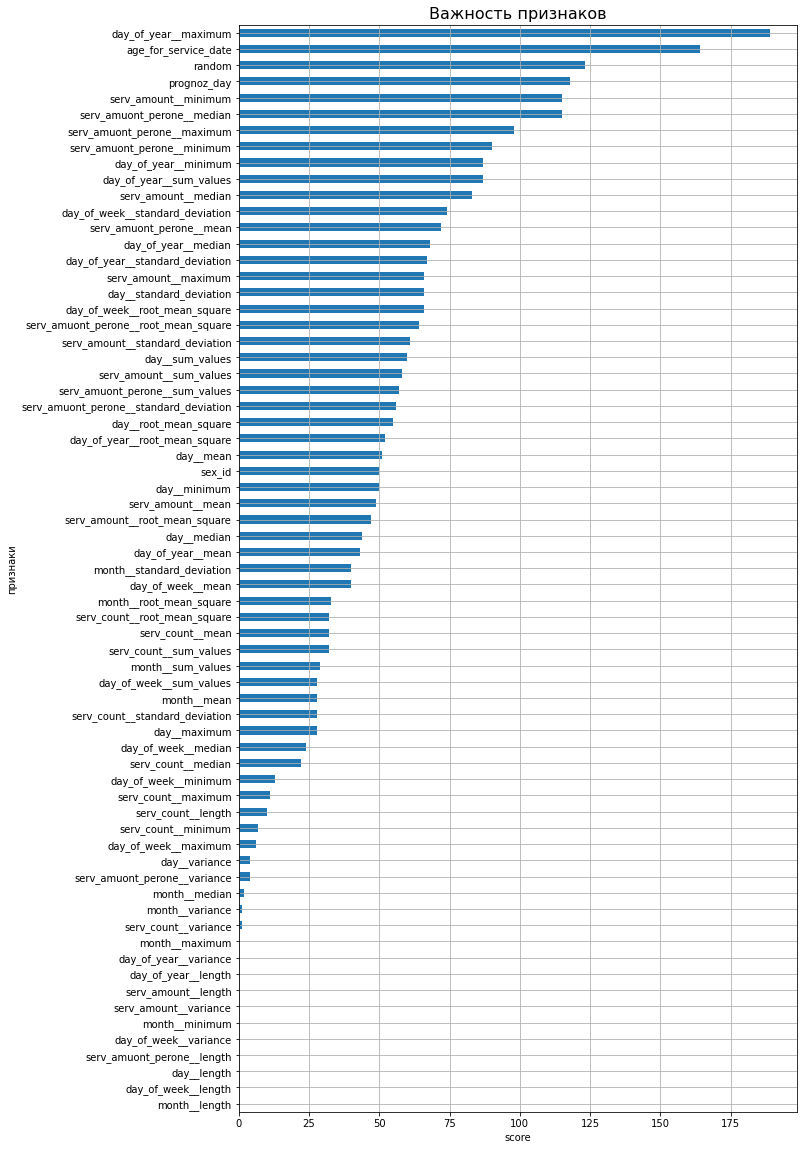

In [64]:
# Выделим признаки
efectiv_score = pd.DataFrame(data={'score': lgbm_clf.feature_importances_}, 
                            index=X.columns).sort_values(by='score')
# Выведем их на экран
ax = efectiv_score.plot(kind='barh', grid=True, figsize=(10,20), legend=False)
ax.set_title("Важность признаков", fontsize=16)
ax.set_ylabel("признаки")
ax.set_xlabel("score")
plt.show;

**Вывод:** 
1. Модель LGBMClassifier без подбора гиперпараметров показывает качество AUC-ROC=0.76 и accuracy=0.75.
2. Оценка важности признаков даёт результат, аналогичный модели CatBoost.

#### 3.1.3 Окончательный выбор признаков

1. Признаки по значимости выше случайного для обоих моделей одинаковые.
2. Возмём по три признака ниже случайного из каждой модели и построим для них корреляционую матрицу.
3. Удалим признаки с высокой взаимной корреляцией

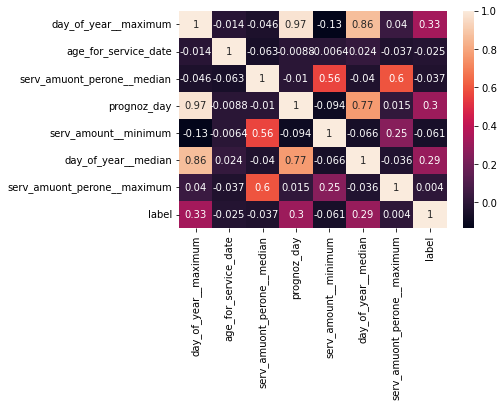

In [65]:

sns.heatmap(df_extracted_features[['day_of_year__maximum',
                                  'age_for_service_date',
                                  'serv_amuont_perone__median',
                                  'prognoz_day',
                                  'serv_amount__minimum',
                                  'day_of_year__median',
                                  'serv_amuont_perone__maximum',
                                  'label'
]].corr(), annot=True);

**Вывод:** Признаки `day_of_year__maximum`,`prognoz_day` и `day_of_year__median` имеют высокую корреляцию. Из них оставим только `day_of_year__maximum`.

Итого набор признаков:
- `day_of_year__maximum`
- `age_for_service_date`
- `serv_amuont_perone__median`
- `serv_amount__minimum`
- `serv_amuont_perone__maximum`

In [66]:
# Список признаков для дальнейшего обучения
best_features = ['day_of_year__maximum',
                 'age_for_service_date',
                 'serv_amuont_perone__median',
                 'serv_amount__minimum',
                 'serv_amuont_perone__maximum'
]
# Отредактируем выборки
X_train = X_train[best_features]
X_valid = X_valid[best_features]
X_test = X_test[best_features]

**Вывод**
Для последующей работы с моделями машинного обучения целесообразно взять признаки которые показывают важность выше чем случайный признак. Также, в связи с небольшим количеством выбраных признаков, возьмём в работу и два признака ниже рандома. Это `serv_amunt_perone__minimum` и ``


### 3.2 Обучение моделей с подбором гиперпараметров
Для удобства создадим две функции:
1. Функцию возвращающую среднее значение метрики качества по результатам кросвалидации.
2. Функцию производящую подбор гиперпараметров и возвращающую метрику качества и гиперпараметры полученные на лучшей модели.

In [67]:
def get_quality(model, features_train=pd.concat([X_train, X_valid]), target_train=pd.concat([y_train, y_valid])):
    """ Принимаем модель и признаки,
        возвращаем ROC-AUC
    """
           
    return round(cross_val_score(model, features_train, target_train, n_jobs=-1, scoring='roc_auc').mean(), 3)

In [68]:
def get_params_cv(model, parametrs, features_train=pd.concat([X_train, X_valid]), target_train=pd.concat([y_train, y_valid])):
    """ Принимаем модель параметры для поиска параметров и признаки,
        возвращаем ROC-AUC и лучшие гиперпараметры
    """
    rs = RandomizedSearchCV(model, 
                            parametrs, 
                            scoring='roc_auc', 
                            cv=5,
                            random_state = SEED,
                            n_jobs=-1
                           )
    rs.fit(features_train, target_train)
    return round(rs.best_score_, 3), rs.best_params_

#### 3.2.1 CatBoostClassifier

In [69]:
cat_clf = CatBoostClassifier(verbose=100,
                             auto_class_weights='Balanced',
                             random_state=SEED
                            )

In [70]:
get_quality(cat_clf)

0.837

In [71]:
%%time
params = {'l2_leaf_reg': range(10, 31),
          'learning_rate': [0.001, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.5],
          'depth' : range(3, 9)
}

get_params_cv(cat_clf, params)

0:	learn: 0.6574050	total: 8.37ms	remaining: 8.36s
100:	learn: 0.4896572	total: 927ms	remaining: 8.25s
200:	learn: 0.4833607	total: 1.8s	remaining: 7.18s
300:	learn: 0.4793840	total: 2.67s	remaining: 6.19s
400:	learn: 0.4761649	total: 3.52s	remaining: 5.25s
500:	learn: 0.4730874	total: 4.35s	remaining: 4.33s
600:	learn: 0.4702494	total: 5.16s	remaining: 3.42s
700:	learn: 0.4677457	total: 5.95s	remaining: 2.54s
800:	learn: 0.4655364	total: 6.83s	remaining: 1.7s
900:	learn: 0.4631671	total: 7.67s	remaining: 842ms
999:	learn: 0.4611917	total: 8.46s	remaining: 0us
CPU times: total: 59.4 s
Wall time: 8min 37s


(0.841, {'learning_rate': 0.1, 'l2_leaf_reg': 18, 'depth': 3})

**Вывод:** На кросвалидации получили метрику качества = 0.838. После подбора гиперпараметров качество улучшилось не значительно = 0.841.

#### 3.2.2 LGBMClassifier

In [72]:
lgbm_clf = LGBMClassifier(class_weight='balanced', random_state=SEED)
get_quality(lgbm_clf)

0.84

In [73]:
%%time
params = { 'n_estimators': range(200, 401, 10),
           'learning_rate': [0.003, 0.005, 0.008, 0.01, 0.02, 0.03, 0.05, 0.07, 0.1, 0.2, 0.5],
           'max_depth': range(20,70),
           'num_leaves': range(30,80),
}

get_params_cv(lgbm_clf, params)

CPU times: total: 5.38 s
Wall time: 25.9 s


(0.841,
 {'num_leaves': 30,
  'n_estimators': 200,
  'max_depth': 56,
  'learning_rate': 0.02})

**Вывод:** На кросвалидации получили метрику качества = 0.84. Подбор гиперпараметров не значительно улучшил качество модели = 0.841.

### 3.2.3 LogicticRegression

Перед обучением логистической регрессии произведём стандартизацию признаков

In [74]:
# Стандартизируем признаки перед обучением линейной модели
scaller = StandardScaler()
X_train_stand = scaller.fit_transform(pd.concat([X_train, X_valid]))
lr_clf = LogisticRegression()
get_quality(lr_clf, X_train_stand)

0.833

In [75]:
%%time
params = {'C':[2,3,4,5,7,10,15,20,40,50]}

get_params_cv(lr_clf, params, X_train_stand)

CPU times: total: 1.17 s
Wall time: 1.92 s


(0.833, {'C': 3})

**Вывод:** Логистическая регрессия даёт качество не сильно хуже чем тяжёлые модели. Подбор кожффициента регуляризации не приводит к улучшению качества.

### 3.2.4 RandomForestClassifier

In [76]:
rf_clf=RandomForestClassifier(random_state=SEED)
get_quality(rf_clf)

0.817

In [77]:
%%time
params = { 'n_estimators': range (80, 301, 10),
              'max_depth': range (10,21,2)}

get_params_cv(rf_clf, params)

CPU times: total: 25.2 s
Wall time: 3min 59s


(0.84, {'n_estimators': 290, 'max_depth': 10})

**Вывод:** Случайный лес тоже показывает качество на уровне бустингов.

**Вывод по разделу**

Все рассмотренные модели машинного обучения показывают примерно одинаковое качество ROC-AUC=0.84. А значит выбор модели целесообразно произвести по времени работы модели. Быстрее остальных работает линейная модель. Медленнее, но немного качественнее работает модель LightGBM. Поэтому, если вычислительных мощьностей достаточно - следует выбрать LightGBM. Если Необходимо экономить ресурсы - следует выбрать линейную модель. Она по качеству лишь немного хуже.


## 4. Проверка модели

1. Проверим работу модели на тестовой выборке.
2. Оценим важность признаков с помощью библиотеки `Shape`.
3. Проверим работу модели на адекватность.
4. Сохраним результат работы модели на тестовой выборке.

### 4.1 Проверка работы модели на тестовой выборке

In [78]:
lgbm_clf = LGBMClassifier(num_leaves=36,
                          n_estimators=220,
                          max_depth=32,
                          learning_rate=0.02,
                          class_weight='balanced',
                          random_state=SEED
)
lgbm_clf.fit(pd.concat([X_train, X_valid]),
             pd.concat([y_train, y_valid])
)

LGBMClassifier(class_weight='balanced', learning_rate=0.02, max_depth=32,
               n_estimators=220, num_leaves=36, random_state=5555)

In [79]:
predict = lgbm_clf.predict(X_test)
roc_auc_score(y_test, predict)

0.7664097959841534

In [80]:
def plt_roc_curve(clf, features, target):
    """Процедура строит roc-кривую и расчитывает метрику auc-roc"""
    # Расчёт вероятности классификации
    probabilities_test = clf.predict_proba(features)
    probabilities_one_test = probabilities_test[:, 1]
    # Получаем данные для построения графика
    fpr, tpr, thresholds = roc_curve(target, probabilities_one_test) 
    # Выводим кривую auc-roc
    plt.figure()
    plt.plot(fpr, tpr, label='Model')
    # ROC-кривая случайной модели
    plt.plot([0, 1], [0, 1], linestyle='--', label='Random')
    plt.xlim([0,1]) 
    plt.ylim([0,1])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC-кривая")
    plt.legend(fontsize=12)
    plt.show()
    # Расчёт метрики auc_roc
    print('auc_roc =', roc_auc_score(target, clf.predict(features)))    

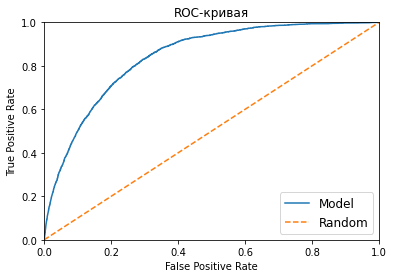

auc_roc = 0.7664097959841534


In [81]:
plt_roc_curve(lgbm_clf, X_test, y_test)

**Вывод:** На тестовой выборке выбранная модель показывает качество хуже чем при перекрёстной проверке примерно на 10%. Думаю, это приемлемый результат. 

### 4.2 Проверка важности признаков

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
auto_size_plot=False is deprecated and is now ignored! Use plot_size=None instead.


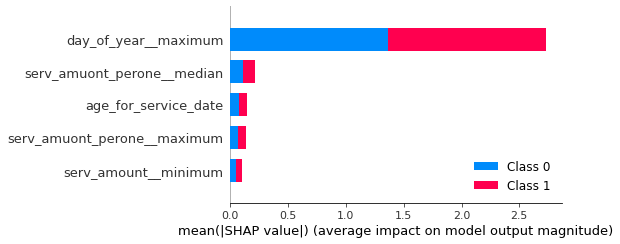

In [82]:
shap_test = shap.TreeExplainer(lgbm_clf).shap_values(X_train)
shap.summary_plot(shap_test, X_train, max_display=20, auto_size_plot=True)

**Вывод:** В целом картина та же что и при проверке важности при выборе признаков. Если-бы стояла задача максимально облегчить модель - можно было-бы оставить один признак "максимальный день обращения в году".

## 4.3 Проверка работы модели на адекватность

Сравним работу модели с работой фиктивной модели.

In [83]:
dummy_model = DummyClassifier(strategy='most_frequent')
dummy_model.fit(pd.concat([X_train, X_valid]),
                pd.concat([y_train, y_valid])
)
dummy_predict = dummy_model.predict(X_test)
roc_auc_score(y_test, dummy_predict)

0.5

**Вывод:** ROC-AUC фиктивной модели = 0.5 - наша модель явно лучше!

### 4.4 Сохранение результатов

В сохраняемом файле будут содержаться:
- `id` - ид застрахованного
- `label` - предсказанные значения целевого признака
- `true_label` - истинными значения целевого признака

In [84]:
df_submission = pd.DataFrame({'id': X_test.index,
                               'label': predict,
                               'true_label':y_test
                             })
df_submission.head()

,id,label,true_label
297861,297861,0,0
411682,411682,1,0
154691,154691,1,0
256718,256718,0,0
544420,544420,0,0


In [85]:
df_submission.to_csv("Test_task_submission.csv", index=False)

**Вывод:** Результаты работы модели на тестовой выборке сохранены.

**Вывод по разделу**

1. Работа модели проверена на тестовой выборке. Считаю что результат вполне удовлетворительный. Метрика ROC-AUC = 0.77. Что на 0.27 лучше, чем показывает фиктивная модель. 
2. Важность признаков, в целом, коррелирует с предыдущими выводами. 
3. Результаты работы модели на тестовой выборке сохранены.

# Общий вывод



1. На этапе Анализа данных произвели загрузку данных и их анализ. Выяснили проблемные вопросы и наметили пути их решения. Так-же возник ряд вопросов, которые  стоило-бы задать владельцу данных или лицу ответственному за сбор датасета.
2. На этапе подготовки данных была произведена их предобработка, выделение дополнительных признаков и формирование целевого признака. Далее, из начального набора данных был сформирован датасет с извлечёнными признаками в результате группировки по ИД застрахованного. И в итоге, финальный набор данных был разделён на выборки: обучающую, валидационную и тестовую.
3. На этапе обучения модели, сначала были обучены две модели с анализом важности признаков. По итогу анализа важности признаков, для дальнейшего обучения моделей, были выбраны только пять признаков. Далее, были обучены несколько моделей, произведён подбор гиперпараметров к ним. Все модели показали примерно равное качество на перекрёстной проверке. По точности и скорости работы, предлагается выбрать модель LigtGBMClassifier.
4. На этапе проверки модели, была произведена проверка её работы на тестовой выборке, с результатом ROC-AUC=0.77, что на 0.27 лучше случайной и константной модели. Произведена оценка важности признаков. Из пяти выбраных признаков, наибольший вклад вности признак "максимальный день обращения в году". Получается, что пол, возраст, стоимость и количество оказанных услуг влияют на решение очень слабо, а день, когда клиент обращался последний раз играет решающее значение.
5. Думаю, что с представленными данными качество модели сильно увеличить не удастся. Для дальнейшего увеличения качества модели необходимо добавление в датасет дополнительных данных. Например данных о болезнях застрахованных, причинах их обращений за медицинской помощью, принимаемых ими препаратах и т.д.